# 고찰

1. 좋아요 수의 평균을 이용하는 건 위험하다
    - 커뮤니티마다 좋아요를 누르는 성향이 너무 극단적으로 다를 듯
    - 좋아요 수의 합은 의미가 있을 것이다
2. 조회수와 좋아요의 지수 감쇄의 가중값은 다르게 해야한다.
    - 조회수는 0.05에서 충분히 활발한 움직임을 보인다.
    - 좋아요는 0.02에서 충분히 활발한 움직임을 보인다.
3. 좋은 피처
    - `movingAverage(0.05, mean(community_normalized(log(View))))`
    - `movingAverage(0.02, sum(community_normalized(log(Like))))`

In [132]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# 0. 데이터 로드 및 이슈 선택

In [133]:
with open('../data/defect_data.json', 'r', encoding='utf-8') as f:
    defect_data = json.load(f)

print("아래 이슈 중 인덱스를 하나 선택하세요")

dfs = []
for i,defect in enumerate(defect_data):
    car_name = defect['car_name']
    defect_type = defect['defect_type']

    df = pd.read_csv(f"../data/defect/{car_name}_{defect_type}_adft.csv") # adft = additional features
    df['Date'] = pd.to_datetime(df['Date'])
    dfs.append(df)

    print(i, car_name, defect_type, df.shape)

아래 이슈 중 인덱스를 하나 선택하세요
0 그랜저 제동 (967, 14)
1 그랜저 단차 (926, 14)
2 그랜저 시동 (1640, 14)
3 팰리세이드 안전벨트 (435, 14)
4 팰리세이드 시동 (1986, 14)
5 아이오닉 누수 (2125, 14)
6 아이오닉 방전 (4160, 14)
7 아이오닉 ICCU (8035, 14)
8 아반떼 전방센서 (926, 14)
9 제네시스 누유 (1359, 14)
10 제네시스 급발진 (271, 14)
11 캐스퍼 누수 (1533, 14)
12 캐스퍼 가속 (411, 14)
13 캐스퍼 떨림 (1158, 14)


In [134]:
ISSUE_INDEX = 13

df = dfs[ISSUE_INDEX]

car_name = defect_data[ISSUE_INDEX]['car_name']
defect_type = defect_data[ISSUE_INDEX]['defect_type']
keywords = defect_data[ISSUE_INDEX]['keywords']
news_dates = defect_data[ISSUE_INDEX]['news_dates']

print("선택한 이슈:")
car_name, defect_type, news_dates

선택한 이슈:


('캐스퍼', '떨림', ['2022-07-31'])

# 1. 그래프 그리기 함수 정의

### 알림을 주는 트리거 시점

In [135]:
def detect_triggers(grouped, y, window=7, std_threshold=2):
    trigger_dates = []

    # 이동 평균과 이동 표준 편차 계산
    grouped['Moving_Avg'] = grouped[y].rolling(window=window).mean()
    grouped['Moving_Std'] = grouped[y].rolling(window=window).std()

    for i in range(window, len(grouped)):
        current_value = grouped[y].iloc[i]
        moving_avg = grouped['Moving_Avg'].iloc[i]
        moving_std = grouped['Moving_Std'].iloc[i]

        # 현재 값이 이동 평균에서 이동 표준 편차의 일정 배수만큼 벗어날 때 감지
        if abs(current_value - moving_avg) > std_threshold * moving_std:
            trigger_dates.append(grouped['Date'].iloc[i])

    return trigger_dates

In [136]:
def plot_column_over_time(grouped, y, news_dates, window=7, alert_threshold=2):
    plt.figure(figsize=(10, 6))
    
    # 데이터 플롯
    plt.plot(grouped['Date'], grouped[y], marker='o', linestyle='None', color='b', label=y, markersize=1)

    # 뉴스 데이터
    for news_date in news_dates:
        plt.axvline(pd.to_datetime(news_date), color='r', linestyle='-', linewidth=2)

    # 급진적인 증가가 발생한 시점을 감지
    trigger_dates = detect_triggers(grouped, y, window, alert_threshold)
    for trigger_date in trigger_dates:
        plt.axvline(pd.to_datetime(trigger_date), color='g', linestyle='--', linewidth=1)

    plt.title(f'[{y}] Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. 날짜별 데이터를 그룹화

In [137]:
# 그룹화
grouped = df.groupby('Date').agg({
    'Normalized_Log_View': 'mean',
    'Normalized_Log_Like': 'sum'
}).reset_index()

### 지수감쇄 이동평균 계산식을 통한 새로운 열 만들기

In [138]:
moving_avg_prefix = 'Moving_Avg'

def apply_moving_average(grouped, column_name, alpha=0.05):
    new_column_name = f'{moving_avg_prefix}_{column_name}'
    grouped[new_column_name] = 0.0

    # 초기 값 설정
    grouped.loc[0, new_column_name] = grouped.loc[0, column_name]

    # 이동 계산식 적용
    for i in range(1, len(grouped)):
        grouped.loc[i, new_column_name] = (
            (1-alpha) * grouped.loc[i-1, new_column_name] + alpha * grouped.loc[i, column_name]
        )

    return grouped

grouped = apply_moving_average(grouped, 'Normalized_Log_View', alpha=0.05)
grouped = apply_moving_average(grouped, 'Normalized_Log_Like', alpha=0.02)

grouped.columns

Index(['Date', 'Normalized_Log_View', 'Normalized_Log_Like',
       'Moving_Avg_Normalized_Log_View', 'Moving_Avg_Normalized_Log_Like'],
      dtype='object')

# 3. 특성 별 경향 분석

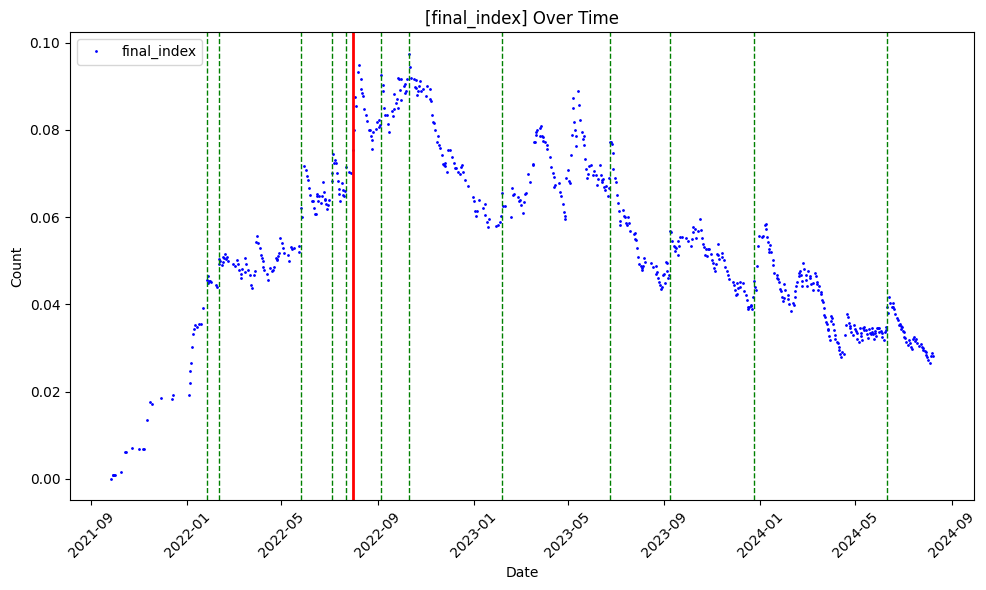

In [139]:
grouped['final_index'] = grouped['Moving_Avg_Normalized_Log_View'] * grouped['Moving_Avg_Normalized_Log_Like']

plot_column_over_time(grouped, 'final_index', news_dates, window=8, alert_threshold=2.1)

# 모든 그래프

그랜저 제동 ['2023-04-10']


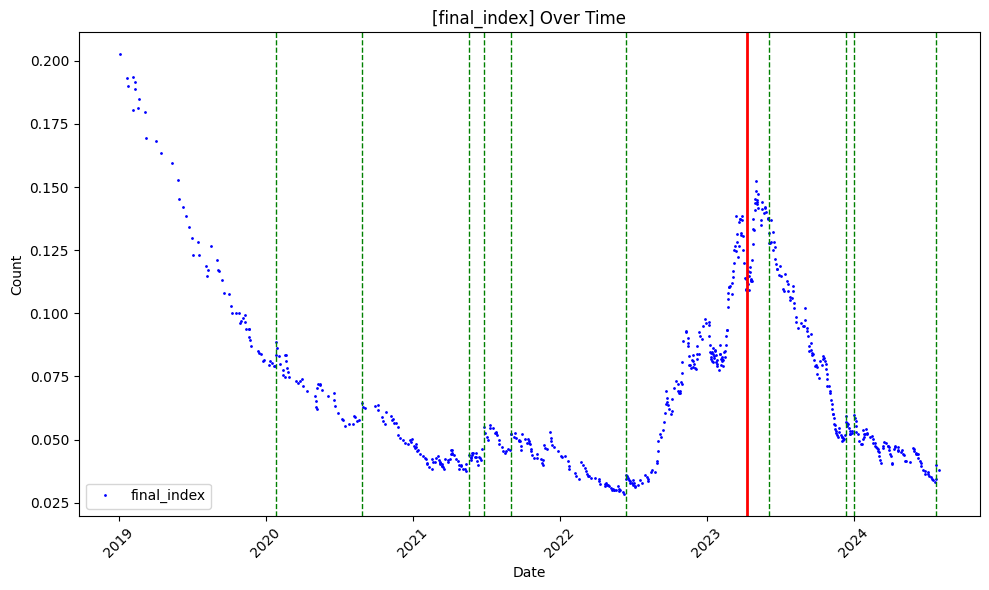

그랜저 단차 ['2023-01-20']


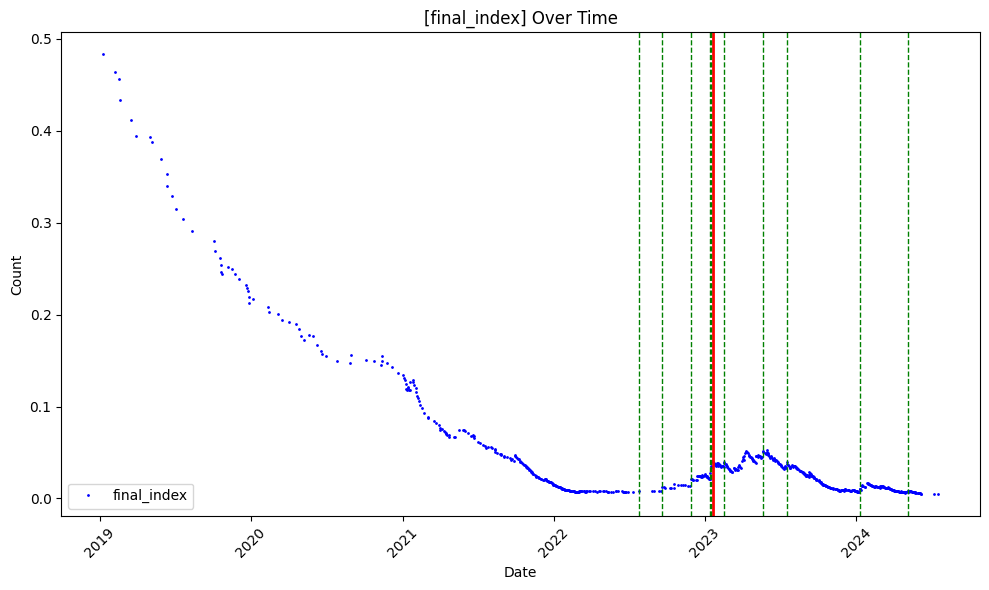

그랜저 시동 ['2020-01-03', '2023-01-09']


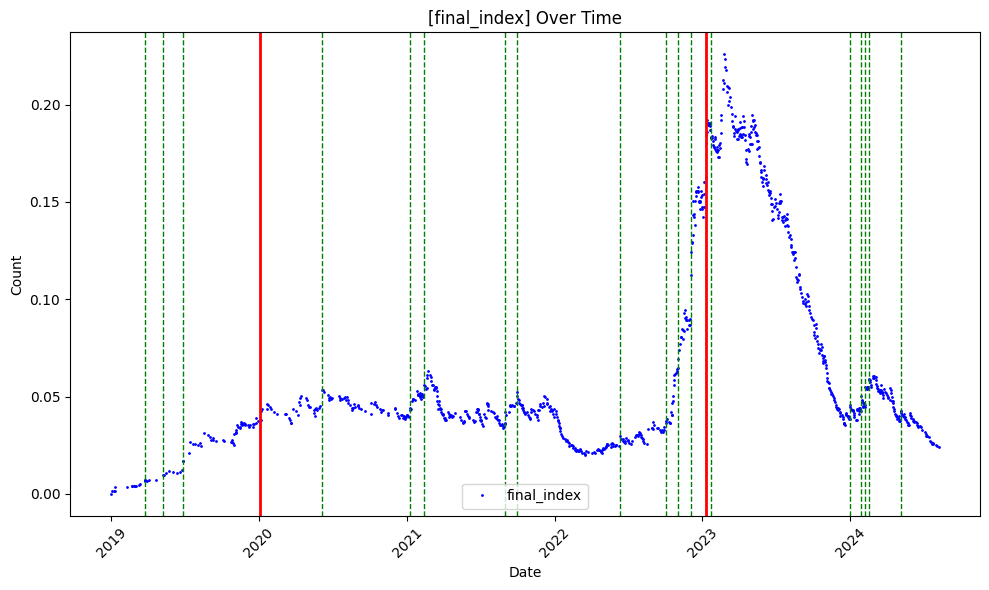

팰리세이드 안전벨트 ['2024-08-10']


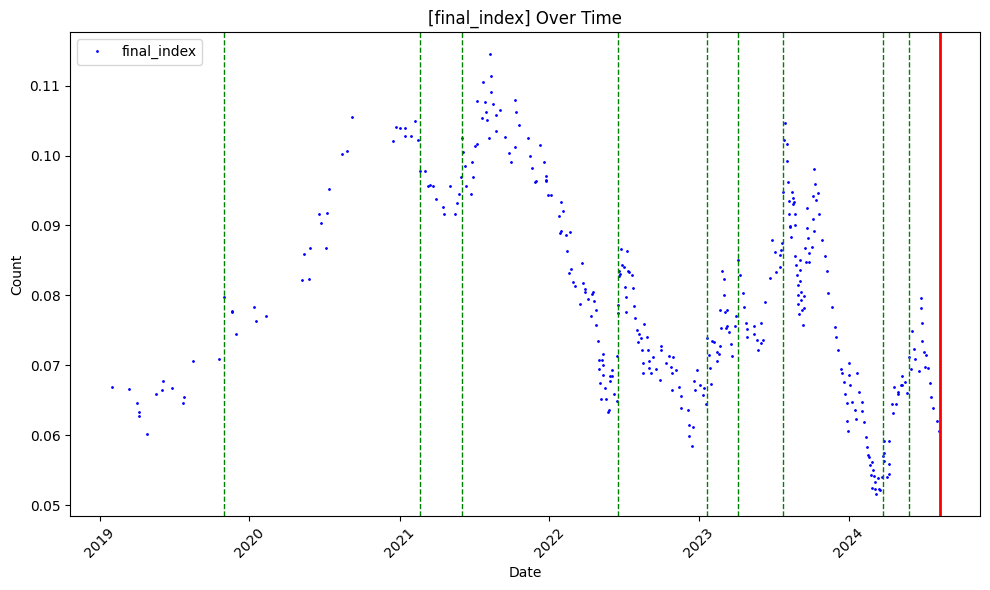

팰리세이드 시동 ['2022-07-11']


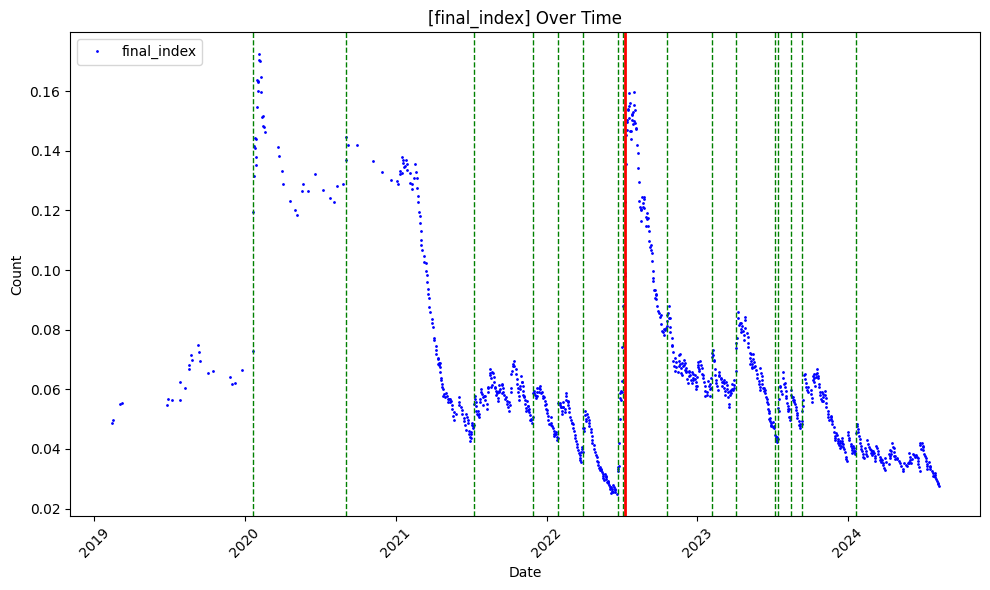

아이오닉 누수 ['2023-10-26']


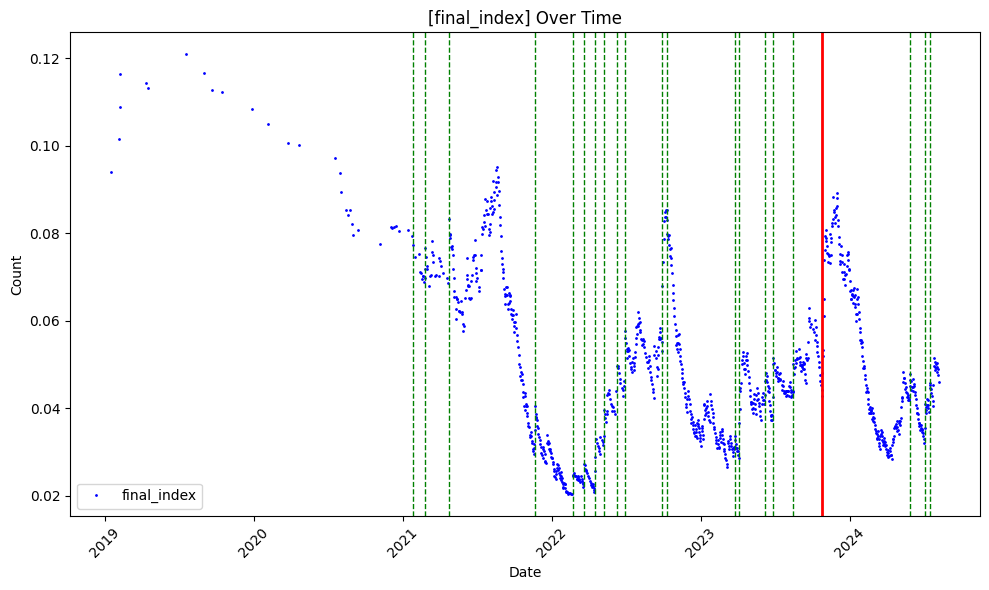

아이오닉 방전 ['2023-03-31', '2023-06-18']


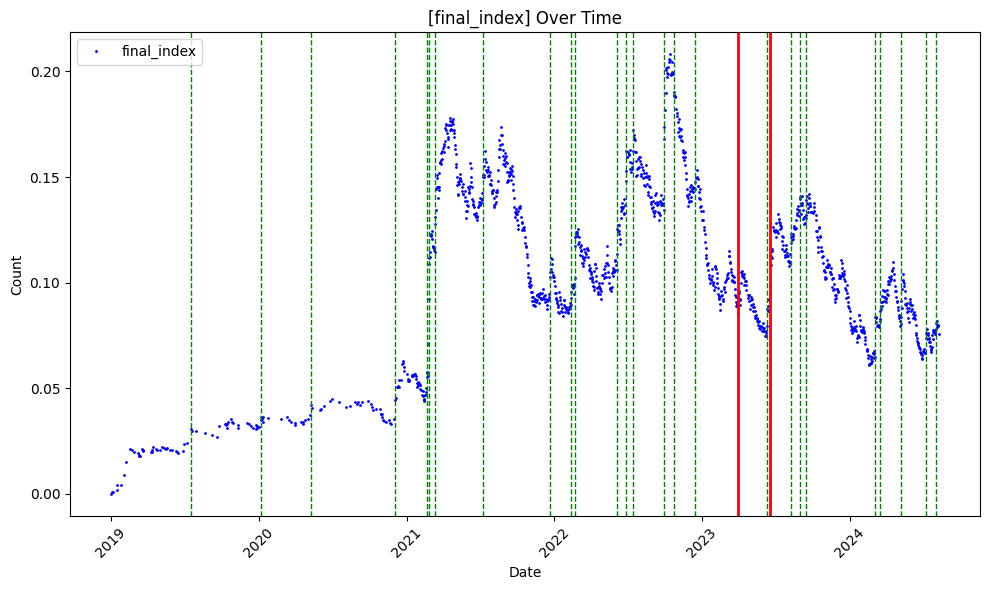

아이오닉 ICCU ['2024-02-20']


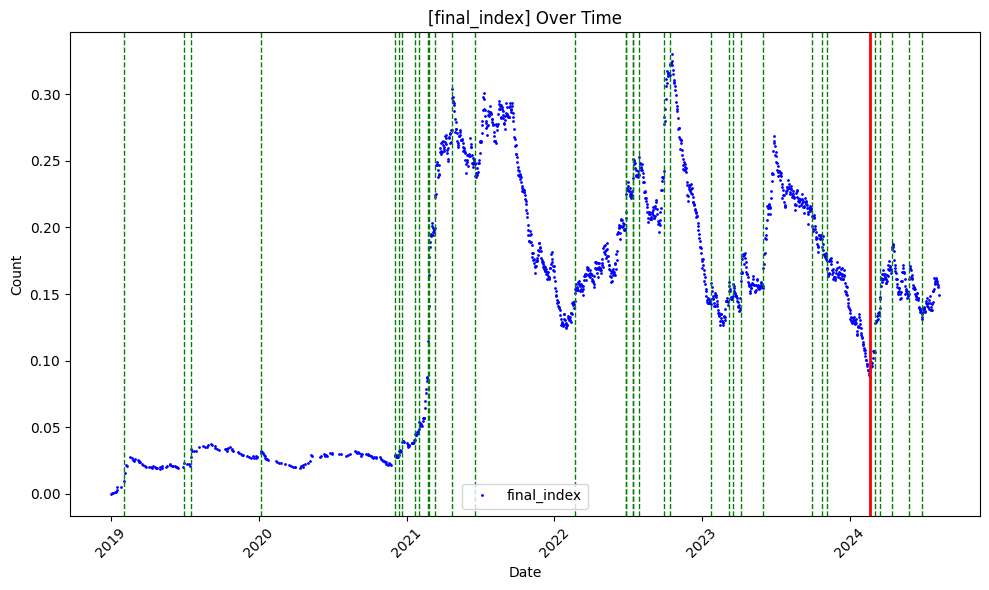

아반떼 전방센서 ['2023-07-28']


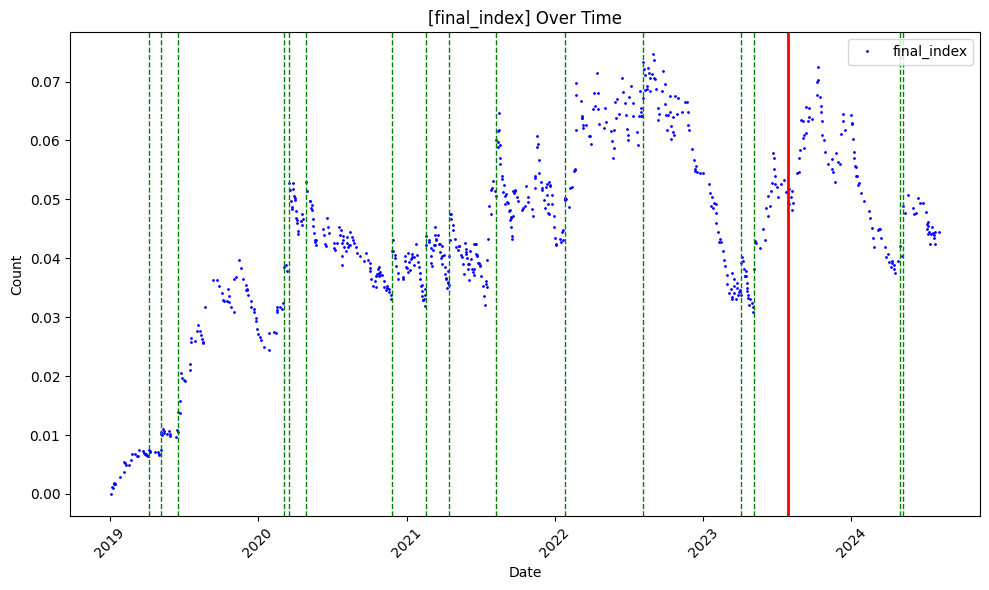

제네시스 누유 ['2019-07-18', '2020-06-24']


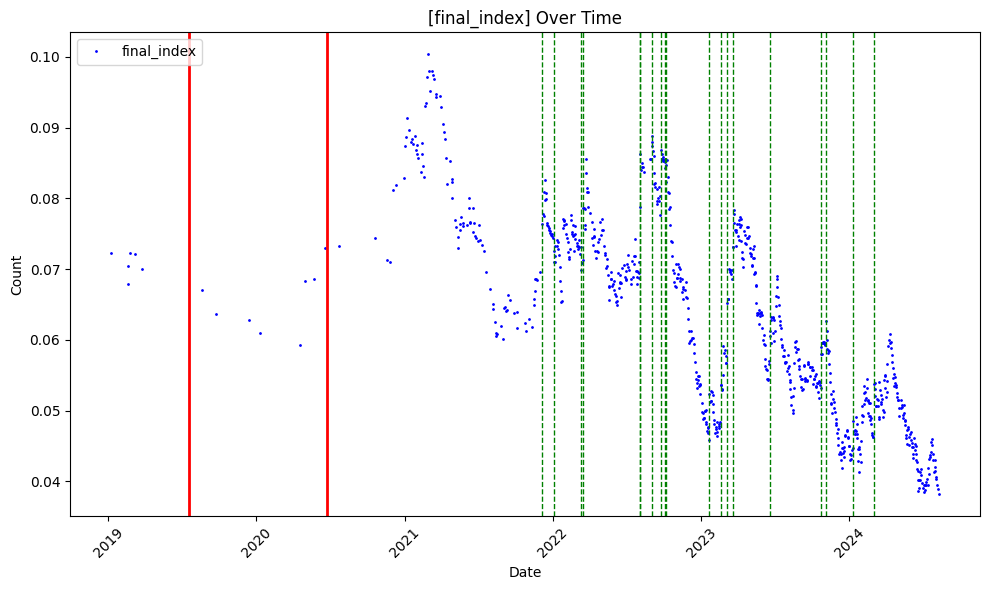

제네시스 급발진 ['2020-02-13', '2020-12-24', '2021-08-18', '2022-04-06', '2023-03-17', '2024-02-11', '2024-07-02']


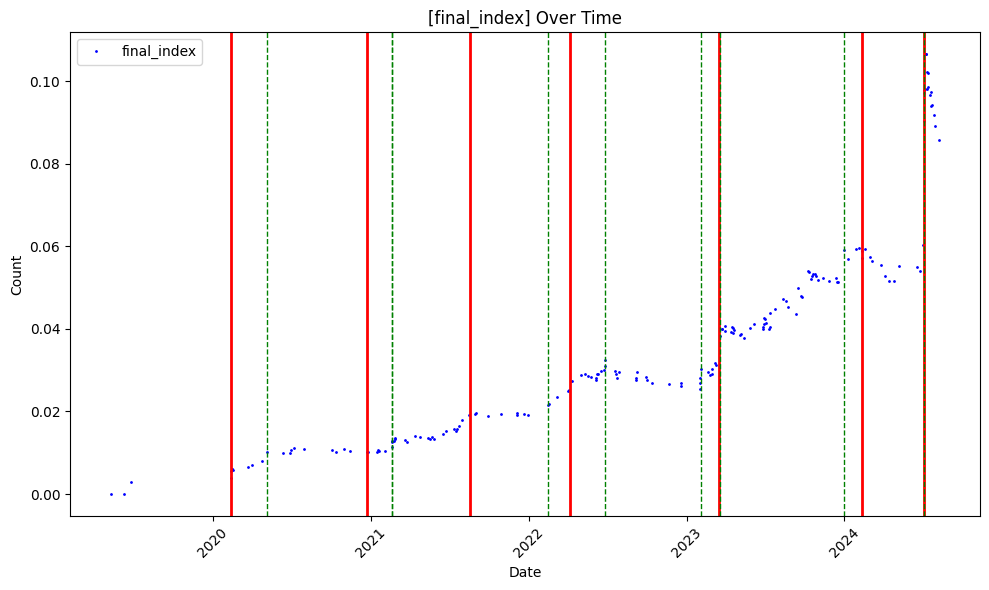

캐스퍼 누수 ['2022-08-05']


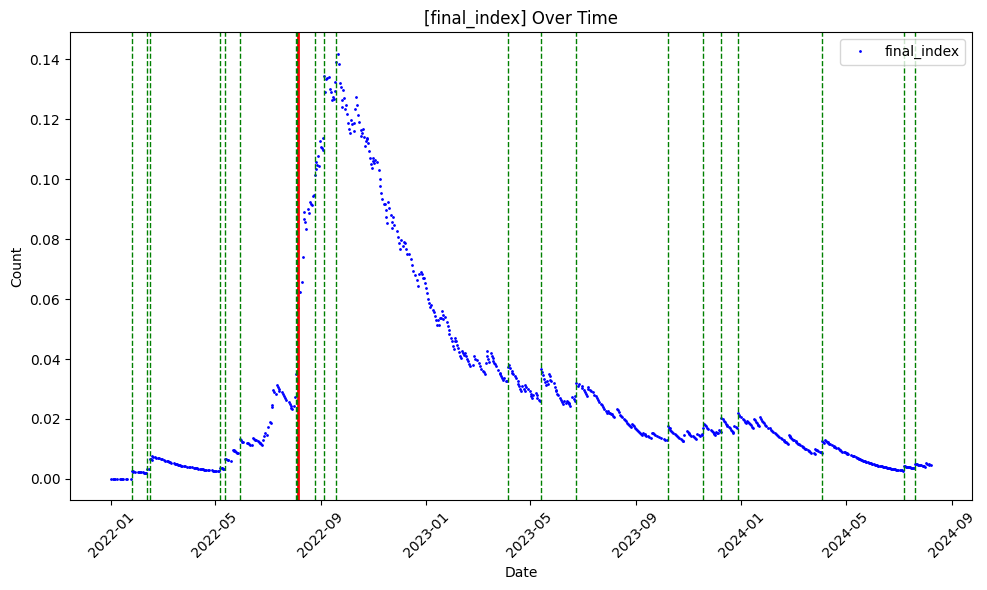

캐스퍼 가속 ['2023-08-04']


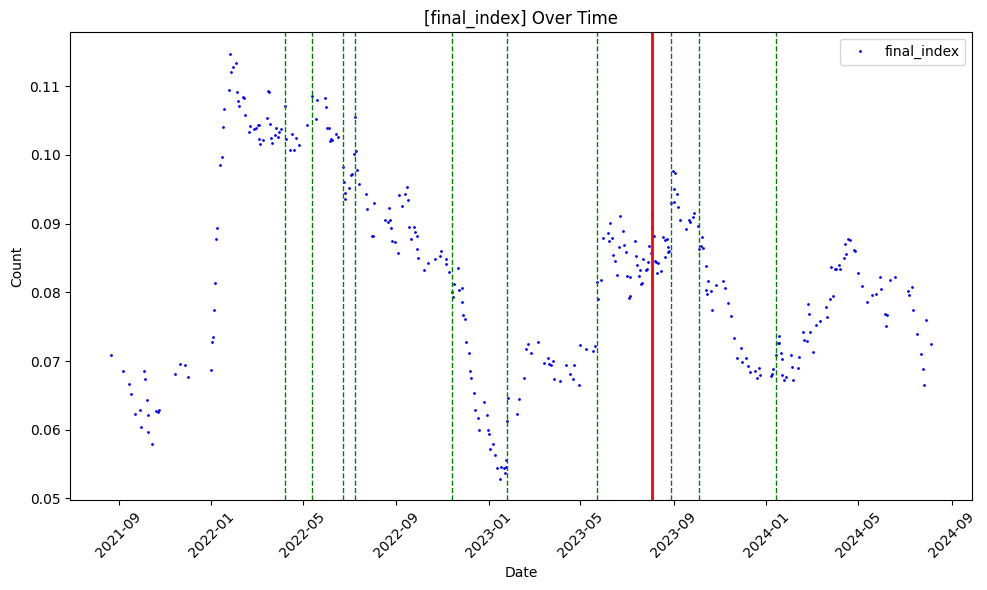

캐스퍼 떨림 ['2022-07-31']


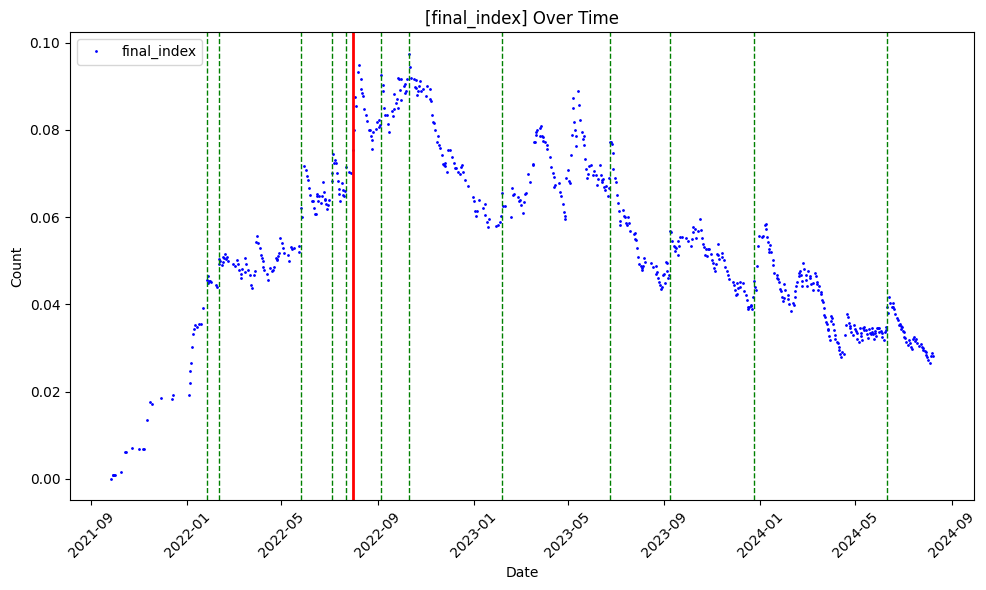

In [140]:
for i in range(len(dfs)):
    df = dfs[i]
    car_name = defect_data[i]['car_name']
    defect_type = defect_data[i]['defect_type']
    keywords = defect_data[i]['keywords']
    news_dates = defect_data[i]['news_dates']

    print(car_name, defect_type, news_dates)

    grouped = df.groupby('Date').agg({
        'Normalized_Log_View': 'mean',
        'Normalized_Log_Like': 'sum'
    }).reset_index()

    grouped = apply_moving_average(grouped, 'Normalized_Log_View', alpha=0.05)
    grouped = apply_moving_average(grouped, 'Normalized_Log_Like', alpha=0.02)

    grouped['final_index'] = grouped['Moving_Avg_Normalized_Log_View'] * grouped['Moving_Avg_Normalized_Log_Like']
    plot_column_over_time(grouped, 'final_index', news_dates, window=8, alert_threshold=2.1)